In [1]:
from validation.TensileExperimental import TensileExperimental
import numpy as np
from scipy.optimize import minimize,basinhopping
import pandas as pd

In [2]:
r = TensileExperimental()

df       = r["df"]
df_stats = r["df_stats"]

layers = df_stats["layers"].values
layers[0] = ["Y","Y"]
df_stats["layers"] = layers

ni = df_stats["ni"].values
ni[0] = 2
df_stats["ni"] = ni

In [3]:
df_stats.round(2)

Et [GPa]       t [mm]         % e       St [MPa]              layers  \
         mean   std   mean   std  mean   std     mean    std                
Name                                                                        
TFP1     2.89  0.23   5.27  0.06  0.12  0.01   279.10  14.34       [Y, Y]   
TFP2     2.26  0.07   4.70  0.00  0.09  0.00   153.36   0.47       [Y, X]   
TFP3     2.00  0.00   4.83  0.06  0.09  0.00   137.11   5.00      [Y, SX]   
TFP4     2.45  0.11   4.70  0.00  0.10  0.01   184.40   1.36      [Y, SY]   
TFP5     1.63  0.12   5.70  0.00  0.09  0.01    99.99   9.79  [Y, SX, SY]   
TFP6     1.74  0.07   5.60  0.00  0.09  0.01   104.51   7.71   [Y, X, SY]   

     v [X,SX,Y,SY] ni  
                       
Name                   
TFP1  [0, 0, 1, 0]  2  
TFP2  [1, 0, 1, 0]  2  
TFP3  [0, 1, 1, 0]  2  
TFP4  [0, 0, 1, 1]  2  
TFP5  [0, 1, 1, 1]  3  
TFP6  [1, 0, 1, 1]  3

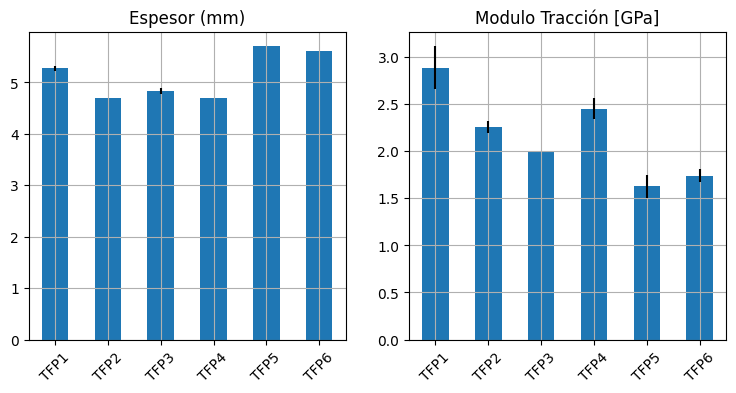

In [4]:
from validation.TensileExperimental import TensilePlotData

TensilePlotData(df_stats)

In [5]:
# only thin 

ni = df_stats["ni"].values
tau_exp = df_stats["t [mm]"]["mean"].values

tau_pred_fcn = lambda tn,tl: tn + 2*tl*ni

In [6]:
from validation.experimental import  nucleo
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [7]:
from validation.experimental import manual_data

t_nucleo_exp = manual_data()["t_nucleo [mm]"]

In [8]:
# min square error


def objective(tn,tl):
    return sum(((tau_pred_fcn(tn,tl) - tau_exp)/tau_exp )**2)

x0 = [0,0]
#
x0 = 2*np.random.rand(2)

bound  = [(0.95*t_nucleo_exp, t_nucleo_exp*1.05), # tn
          (0, None)] # tl


res = minimize(lambda x: objective(*x), x0, method='Nelder-Mead', 
               bounds=bound)

tn_opt = res.x[0]
tl_opt = res.x[1]

tau_pred = tau_pred_fcn(tn_opt,tl_opt)


C:\Users\djoroya\AppData\Local\Temp\ipykernel_8108\4069302859.py:15: OptimizeWarning: Initial guess is not within the specified bounds
  res = minimize(lambda x: objective(*x), x0, method='Nelder-Mead',


In [9]:
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)
print("Residuals: ", res.fun)

Optimal tn:  2.9337
Optimal tl:  0.46758705135327033
Residuals:  0.009397992120475427


In [10]:
# Tau predicted
print("Tau predicted: ", tau_pred)
print("Tau experimental: ", tau_exp)

df_exp = pd.DataFrame({"tau_exp": tau_exp, "tau_pred": tau_pred})
df_exp["error [%]"] = 100*abs(df_exp["tau_exp"] - df_exp["tau_pred"]) / df_exp["tau_exp"]
# round to 2 decimals
df_exp = df_exp.round(2)
df_exp

Tau predicted:  [4.80404821 4.80404821 4.80404821 4.80404821 5.73922231 5.73922231]
Tau experimental:  [5.26666667 4.7        4.83333333 4.7        5.7        5.6       ]


,tau_exp,tau_pred,error [%]
0,5.27,4.80,8.78
1,4.70,4.80,2.21
2,4.83,4.80,0.61
3,4.70,4.80,2.21
4,5.70,5.74,0.69
5,5.60,5.74,2.49


In [11]:
def E_effective_j(En,Evec,j):
    
    delta_j  = df_stats["v [X,SX,Y,SY]"].iloc[j]
    tau_j    = tau_pred[j]

    return (En*tn_opt + 2*tl_opt*(np.dot(delta_j,Evec)))/tau_j

def E_effective(En,Evec):
    return np.array([E_effective_j(En,Evec,j) for j in range(len(df_stats))])


In [12]:
E_eff_exp = df_stats["Et [GPa]"]["mean"].values

Evec_0 = np.array([1,0,0,0])
En_0 = 1000

E_eff_pred = E_effective(En_0,Evec_0)

In [13]:
from validation.experimental import  nucleo
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [14]:
# minimize 
def objective_E(En,Evec):
    return sum((E_effective(En,Evec) - E_eff_exp)**2)

x0 = np.random.rand(5)
# must be positive 
# v [X,SX,Y,SY]
bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (0.0,None), # Evec[0]   # X
            (0.0,None), # Evec[1]   # SX
            (0.0,None), # Evec[2]   # Y
            (0.0,None), # Evec[3]   # SY
            ]

minimize_kwargs = {
    'method':'Nelder-Mead',
    'bounds': bounds
}

res = basinhopping(lambda x: objective_E(x[0],x[1:]),
                x0, 
                minimizer_kwargs=minimize_kwargs,
                niter=50)


En_opt = res.x[0]
Evec_opt = res.x[1:]


E_eff_pred = E_effective(En_opt,Evec_opt)

c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\.conda\Lib\site-packages\scipy\optimize\_basinhopping.py:294: OptimizeWarning: Initial guess is not within the specified bounds
  return self.minimizer(self.func, x0, **self.kwargs)


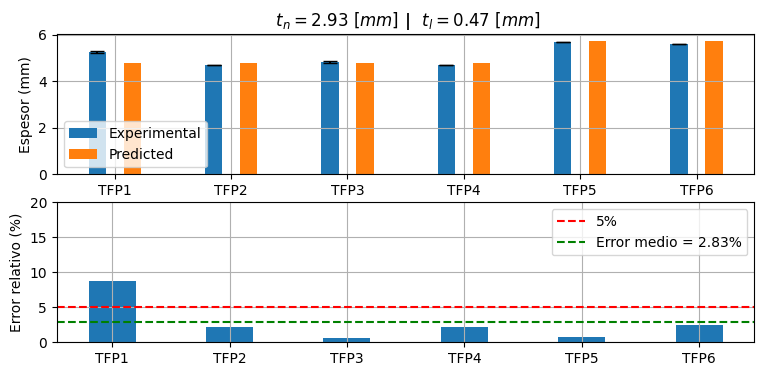

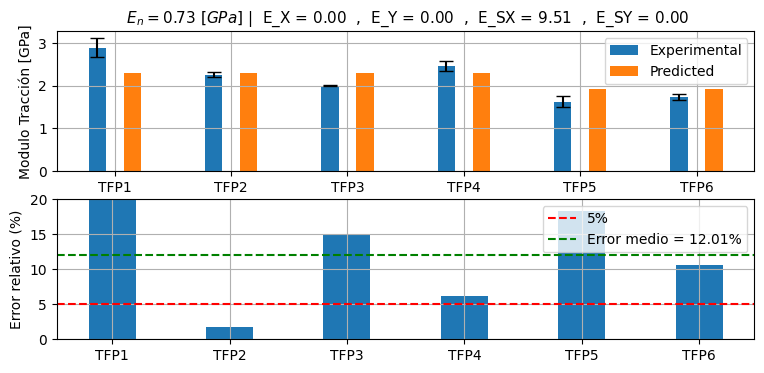

In [15]:
from AnalyticalLayers.plot_E import plot_E
from AnalyticalLayers.plt_thin import plt_thin

plt_thin(df_stats, tau_exp, tau_pred, tn_opt, tl_opt)
plot_E(df_stats, E_eff_exp, E_eff_pred, Evec_opt, En_opt)

In [16]:
print("Optimal En: ", En_opt)
print("Optimal Evec: ", Evec_opt)
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

Optimal En:  0.7307972254997385
Optimal Evec:  [0.         0.         9.51381637 0.        ]
Optimal tn:  2.9337
Optimal tl:  0.46758705135327033


In [17]:
df_layers = pd.DataFrame({"Evec [GPa]": Evec_opt}, index=["X","SX","Y","SY"])
# add nuclueo
df_layers.loc["Nucleo"] = [En_opt]
df_layers.round(2)

,Evec [GPa]
X,0.00
SX,0.00
Y,9.51
SY,0.00
Nucleo,0.73


In [18]:
df_thickness = pd.DataFrame({"t [mm]": [tn_opt, tl_opt]}, index=["Nucleo","Capas"])

df_thickness.round(2)

,t [mm]
Nucleo,2.93
Capas,0.47


In [19]:
df_pred = {
    "Name"          : df_stats.index,
    "E pred [GPa]"  : E_eff_pred,
    "E exp [GPa]"   : E_eff_exp,
    "E e rel [%]"   : 100*abs(E_eff_exp - E_eff_pred)/E_eff_exp,
    "t pred [mm]"   : tau_pred,
    "t exp [mm]"    : tau_exp,
    "t e rel [%]"   : 100*abs(tau_exp - tau_pred)/tau_exp
}
df_pred = pd.DataFrame(df_pred)
# decimals
df_pred = df_pred.round(2)
df_pred.head()

,Name,E pred [GPa],E exp [GPa],E e rel [%],t pred [mm],t exp [mm],t e rel [%]
0,TFP1,2.30,2.89,20.35,4.80,5.27,8.78
1,TFP2,2.30,2.26,1.76,4.80,4.70,2.21
2,TFP3,2.30,2.00,14.89,4.80,4.83,0.61
3,TFP4,2.30,2.45,6.25,4.80,4.70,2.21
4,TFP5,1.92,1.63,18.27,5.74,5.70,0.69


In [20]:
Em_error = np.mean(df_pred["E e rel [%]"])
tm_error = np.mean(df_pred["t e rel [%]"])

from loadsavejson.savejson import savejson

savejson({"layers":df_layers, 
            "errors": {"E":Em_error, "t":tm_error},
          "thickness":df_thickness},
          "df_opt_fix_thin.json")